In [50]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Step 1: Download and Prepare the Data

In [51]:
# Download data for stock and index
stock = yf.download("SAP.DE", start="2023-01-01", end="2024-12-31")
index = yf.download("^GDAXI", start="2023-01-01", end="2024-12-31")
print(index.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open    Volume
Ticker            ^GDAXI        ^GDAXI        ^GDAXI        ^GDAXI    ^GDAXI
Date                                                                        
2023-01-02  14069.259766  14095.910156  13976.440430  13992.709961  34978500
2023-01-03  14181.669922  14293.870117  14083.759766  14116.070312  57907500
2023-01-04  14490.780273  14492.780273  14264.599609  14266.980469  76221600
2023-01-05  14436.309570  14501.599609  14403.730469  14451.230469  60947500
2023-01-06  14610.019531  14610.230469  14388.980469  14476.719727  55433700


In [52]:
# Convert the relevant data into NumPy arrays
dates = np.array(index.index)  # Dates
index_close = index['Close'].values  # S&P 500 close prices
stock_close = stock['Close'].values  # AMD close prices

In [53]:
# Remove NaN values (align data)
valid_indices = ~np.isnan(index_close) & ~np.isnan(stock_close)
print(valid_indices.shape)
dates = dates[np.squeeze(valid_indices)]  #dates has only dimension --> squeezing of valid_indeces necessary
index_close = index_close[valid_indices]
stock_close = stock_close[valid_indices]

(509, 1)


# Step 2: Compute 𝑥 (S&P Daily Change) and 𝐶𝑘  (AMD Movement)

In [54]:
# Calculate daily change in index closing prices
index_change = np.diff(index_close)  # Daily change
index_change = np.insert(index_change, 0, 0)  # Add a 0 for the first day to keep the same length

# Calculate stock movement for tomorrow (1: rises, 0: drops)
stock_tomorrow = np.roll(stock_close, -1)  # Shift AMD prices by 1 day
stock_movement = (stock_tomorrow > stock_close).astype(int)  # 1 if rises, 0 if drops
stock_movement = stock_movement[:-1]  # Remove the last invalid entry

# Adjust arrays to match lengths
index_change = index_change[:-1]  # Exclude the last entry
dates = dates[:-1]

# Step2 Fitting Likelihoods for  𝑃(𝑥∣𝐶1) and 𝑃(𝑥∣𝐶2)

Fit Gaussian distributions to the data using NumPy and SciPy:

In [55]:
# Separate data into C1 (stock rises) and C2 (stock drops)
x_c1 = index_change[stock_movement == 1]  # S&P changes when AMD rises
x_c2 = index_change[stock_movement == 0]  # S&P changes when AMD drops

# Fit Gaussian distributions
mu_c1, std_c1 = norm.fit(x_c1)  # Mean and std for C1
mu_c2, std_c2 = norm.fit(x_c2)  # Mean and std for C2

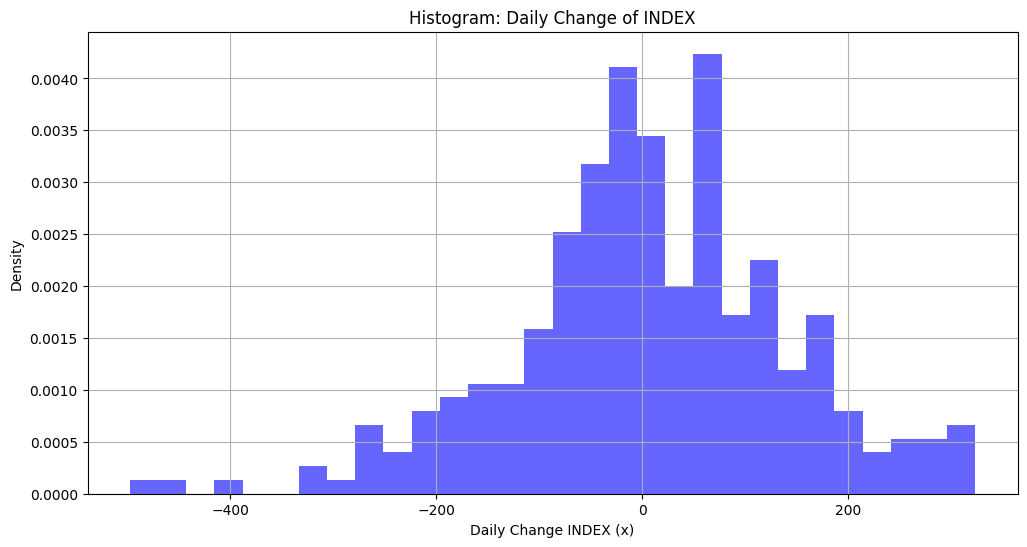

In [56]:
# Plot P(x|C1) as a histogramm to get an impression of the possible distribution behind the data
plt.figure(figsize=(12, 6))
plt.hist(x_c1, bins=30, density=True, alpha=0.6, color='blue', label="Histogram of Data")
plt.title("Histogram: Daily Change of INDEX")
plt.xlabel("Daily Change INDEX (x)")
plt.ylabel("Density")
plt.grid()
plt.show()

# 3. Define the Bayesian Decision Rule

In [57]:
# Calculate priors
p_c1 = np.mean(stock_movement)  # Proportion of days AMD rises
p_c2 = 1 - p_c1  # Proportion of days AMD drops

In [58]:
# Generate x values for plotting
x_values = np.linspace(min(index_change), max(index_change), 500)

# Calculate likelihoods
likelihood_c1 = norm.pdf(x_values, mu_c1, std_c1)
likelihood_c2 = norm.pdf(x_values, mu_c2, std_c2)

# Posterior probability ratios
posterior_ratio = (likelihood_c1 * p_c1) / (likelihood_c2 * p_c2)

# Decision threshold: assume equal losses for simplicity (L21 = L12)
decision_threshold = 1.6  # L21 / L12
decision = posterior_ratio > decision_threshold  # Decide R1 if True, R2 if False

# Visualization

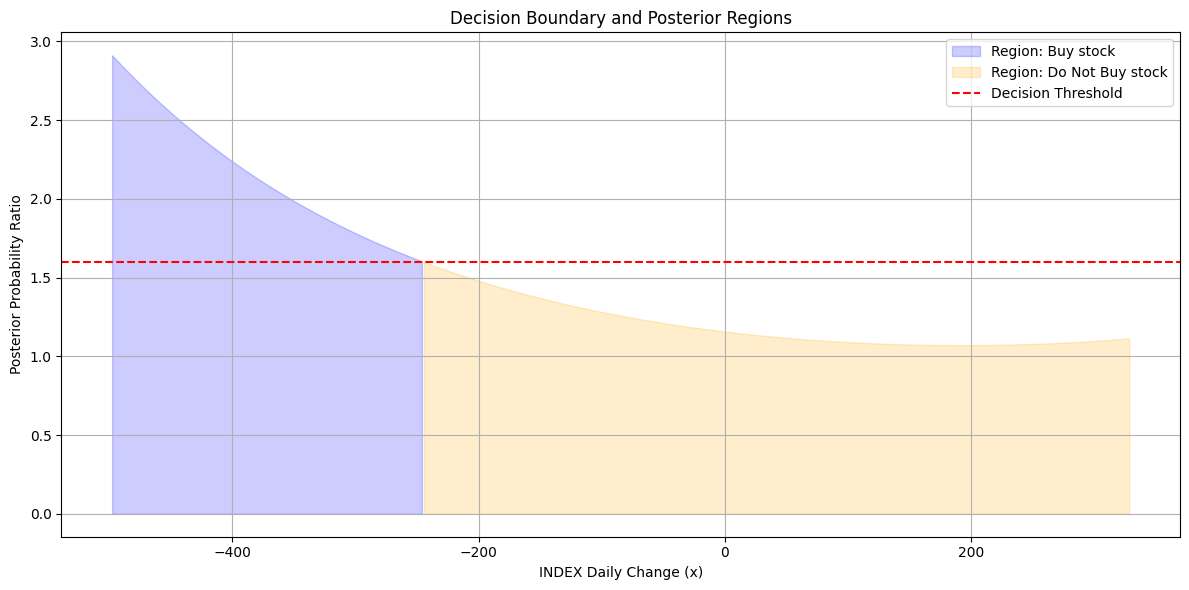

In [59]:
# Plot decision boundary and filled regions
plt.figure(figsize=(12, 6))

# Fill regions
plt.fill_between(x_values, 0, posterior_ratio, where=decision, color='blue', alpha=0.2, label="Region: Buy stock")
plt.fill_between(x_values, 0, posterior_ratio, where=~decision, color='orange', alpha=0.2, label="Region: Do Not Buy stock")

# Add decision threshold line
plt.axhline(y=decision_threshold, color='red', linestyle='--', label="Decision Threshold")

# Set labels and title
plt.title("Decision Boundary and Posterior Regions")
plt.xlabel("INDEX Daily Change (x)")
plt.ylabel("Posterior Probability Ratio")
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()